# **VISUM Summer School 2021 - Trustworthy AI Hands-on Session**

Authors: *Clemens Seibold (Fraunhofer HHI), Johannes Künzel (Fraunhofer HHI), Peter Eisert (HU Berlin, Fraunhofer HHI)*

**Objectives:**


*   Learn to implement and use LRP in PyTorch with different propagation rules
*   Apply LRP to uncover undesired correlations in the data that are learnt by a Deep Convolutional Network (Clever-Hans effect)


This CoLab notebook consists of three parts: The implementation of three different LRP rules in PyTorch, an example that uncovers a Clever-Hans detector for gender classification and an exercise. During the exercise you can apply the described idea to uncover another Clever-Hans detector. To achieve this, you will have to select appropriate LRP rules and apply them on image data that we provide.




##**Import Python Packages and Download Necessary Resources**
The necessary stuff to import packages and get example data.

Please, before running the following code, access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/drive/folders/1PYTPHqJhav3jJvGGRMf0pU4gA8Td6RsI?usp=sharing


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt

#import gdown
#gdown.download("https://drive.google.com/uc?id=1eU6yVfgowy8VrDkKRf9p6jHP5eiC1FHC", "data.zip", quiet=False)
#!unzip -qq data.zip

from google.colab import drive
drive.mount('/content/drive')

!unzip -qq '/content/drive/MyDrive/data.zip' -d 'data'

from data.SimpleClassificationNet import SimpleClassificationNet as SimpleDNN

print('Setup complete')

Mounted at /content/drive
Setup complete


##**LRP Implementation in PyTorch**

In the following, we will implement LRP in PyTorch. The basic idea of this implementation is also described in detail in the LRP tutorial: https://git.tu-berlin.de/gmontavon/lrp-tutorial

Just as a reminder: "*Layer-wise Relevance Propagation (LRP) is a method that identifies important pixels by running a backward pass in the neural network. The backward pass is a conservative relevance redistribution procedure, where neurons that contribute the most to the higher-layer receive most relevance from it." (Source: www.heatmapping.org)* 


We will implement three different LRP rules and describe them in detail.

### **Auxiliary Functions**


First we define two auxiliary functions that will make our lives easier.

*newlayer(layer, g)* copies a torch layer and applies the function g on its weight and bias

*toconv(layers, number_feature_channels)* transforms all fully-connected layers into equivalent convolutional layers

In [ ]:
def newlayer(layer, g):
    layer = copy.deepcopy(layer)
    try: layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def toconv(layers, number_feature_channels):
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer,nn.Linear):
            newlayer = None
            if i == 0:
                m, n = number_feature_channels, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

### **The Actual LRP Implementation**

In the following, we describe a function that calculates an LRP heatmap for a given model, image, ruleset and class id. We implement three different LRP rules.


####**Definitions**

We describe how the relevance $R_j$ for a neuron $j$ is calculated based on the set $K$ of all neurons in the subsequent convolutional layer that have a connection to this neuron. The activation of $j$, after applying a ReLU layer (iff there is one in the network architecture), is denoted by $a_j$ and the weight from a neuron $j$ to neuron $k$ as $w_{j,k}$. $J(k)$ denotes all neurons in $k$'s previous convolutional layer that have a connection to $k$. In order to consider the bias of a neuron, we define $a_0=1$ and $w_{0,k}$ denotes the bias of neuron $k$. The activation of a neuron $k$ without applying the ReLU is denoted by $\hat a_k$.

We define LRP rules only for convolutional layers and transform the fully connected layers into equivalent convolutional layers.

An example configuration is depicted in the following graph:

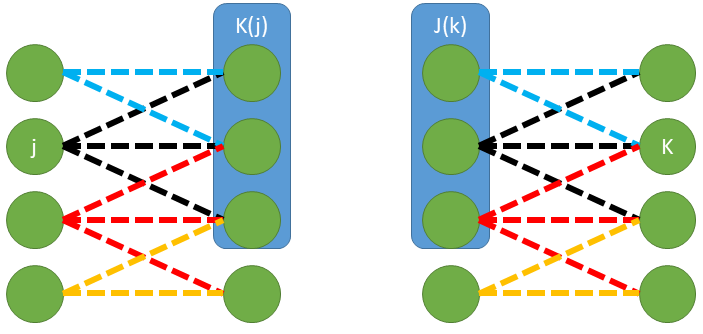



####**Flat Decomposition**
$R_j = \sum_{k \in K} R_k$ 

The flat composition rules distributes the relevance of a neuron equally to all connected neurons in the previous convolutional layer. The activations and weights are ignored. This rule works well for the first convolutional layers of a DNN. In many publications, you can see an additional sum in the denominator. This sum is the reciprocal of the filter size and servers as scaling factor to ensure the relevance conservation principle [Bach15].

[Bach15] Bach S, Binder A, Montavon G, Klauschen F, Müller K-R, Samek W (2015) On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation. PLoS ONE 10(7): e0130140. https://doi.org/10.1371/journal.pone.0130140

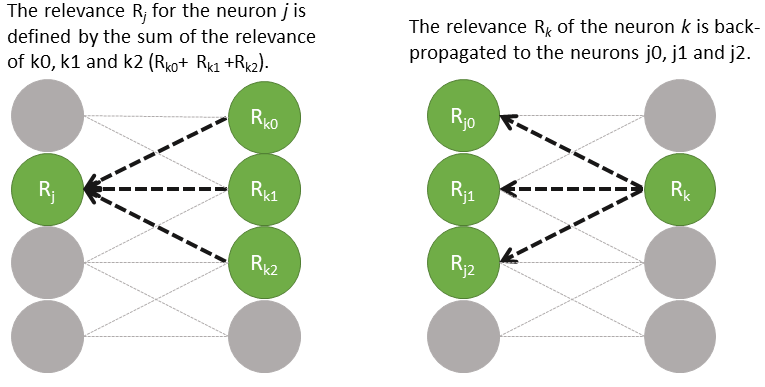

####**Epsilon Decomposition**
$R_j = \sum_{k \in K} \frac{a_j w_{j,k}}{\epsilon + \hat a_k} R_k$

The relevance $R_j$ for the neuron $j$ is calculated by a weighted sum of the relevance of $k0$, $k1$ and $k2$. The weight is the quotient of j’s activation multiplied by the weight from $j$ to $k$ and divided by the activation of $k$ (without applying the ReLU) plus a small epsilon. This decomposition rule works well for the last layers of a DNN.

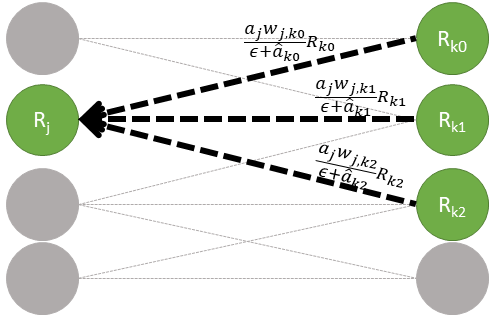

####**Alpha-Beta Decomposition**
$R_j = \sum_{k \in K}\left(\alpha \frac{(a_j w_{j,k})^+}{(\hat a_k)^+} - \beta \frac{(a_j w_{j,k})^-}{(\hat a_k)^-} \right)R_k$

with 

$(\hat a_k)^+ = \sum_{j \in 0,J(k)}(a_j w_{j,k})^+$,

$(\hat a_k)^- = \sum_{j \in 0,J(k)}(a_j w_{j,k})^-$,

$(\cdot)^+ = \max(0, \cdot)$ and $(\cdot)^- = \min(0, \cdot)$

The relevance $R_j$ for the neuron $j$ is again calculated by a weighted sum of the relevance of $k0$, $k1$ and $k2$. This time, the weights are calculated differently for positive and negative weights. A blue arrow denotes a connection with a negative weight and a red arrow a connection with a positive weight.  $(\hat a_{𝑘})^+$ is the activation of the neuron $k$ (again before applying the ReLU) if we consider only  positive contributions (connections with positive weights) and $(\hat a_{𝑘})^-$ if we consider only negative contributions. This rule allows to treat activating and inhibiting parts differently. By choosing different factors for $\alpha$ and $\beta$, the focus can be set on only activating (e.g. $\alpha = 1$ and $\beta = 0$) or on activating and inhibiting features (e.g. $\alpha=2$ and $\beta=1$). It is recommended to set $\alpha - \beta = 1$ to ensure the relevance conservation principle and reduce the amount of free parameters.

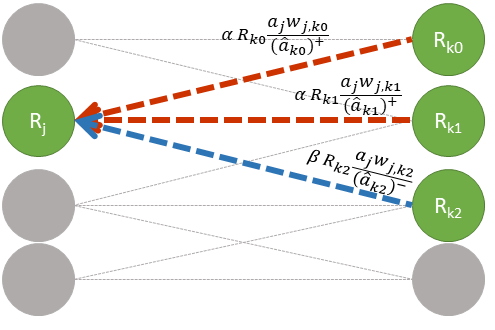

#### **Python Implementation of the Flat, Alpha-Beta and Epsilon Decomposition**

In [ ]:
def lrp_heatmap(model, img, rules, class_id):
    """
    lrp_heatmap(model, img, rules, class_id)

    Calculates an LRP heatmap.

    Parameters
    ----------
    model : DNN model, should consist of a list of feature layers (model.features) 
	          and a classifier (model.classifier) of type sequential.
    img : ndarray
        The image that should be analyzed.
    rules : list of strings
	      LRP rules that should be used. One element for each layer in 
        model.features and model.classifier.
    class_id : int   
        LRP start class. Use -1 for class with largest score.
    Returns
    -------
    res1 : ndarray
        heatmap
    res2 : ndarray
        prediction values for all classes    
    """
    
    # transform the fully connected layers to convolutional layers
    for layer in model.features[::-1]:
        if type(layer) == nn.Conv2d:
            num_out_channels = layer.out_channels
            break
    num_classes = model.classifier[-1].out_features
    layers = list(model.features) + toconv(list(model.classifier), num_out_channels)


    # calculate class prediction and hidden representations
    X = torch.FloatTensor(img[np.newaxis, :, :, :])
    L = len(layers)
    A = [X] + [None] * L
    for l in range(L):
        A[l + 1] = layers[l].forward(A[l])

    if class_id == -1:
        class_id = np.argmax(A[-1].detach().numpy())


    # Here starts the layer-wise backpropagation (LRP)

    # defined starting class for relevance 
    T = torch.FloatTensor((1.0 * (np.arange(num_classes) == class_id).reshape([1, num_classes, 1, 1])))
    R = [None] * L + [torch.abs((A[-1] * T).data)]

    L = len(layers)
    # backpropagation (from the last to the first layer)
    for l in range(0, L)[::-1]:
        A[l] = (A[l].data).requires_grad_(True)

        # for the relevance backpropagation it is recommended to substitute the max pooling layers by averaging layers
        if isinstance(layers[l],torch.nn.MaxPool2d): 
          layers[l] = torch.nn.AvgPool2d(2)

        # backpropagation for convolutional layers and pooling layers
        # remember that we substituted the fully-connected layers by convolutional layers
        if isinstance(layers[l], torch.nn.Conv2d)  or isinstance(layers[l], torch.nn.AvgPool2d):

            # The flat relevance propagation is like a backward pass with equal 
            # weights. It distributes the relevance equally to all neurons 
            # in the previous layer within the range of the filter kernel. 
            if rules[l] == "flat":
                z = newlayer(layers[l], lambda p: p * 0 + 1).forward(A[l])
                s = (R[l + 1]).data
                (z * s).sum().backward();
                c = A[l].grad
                R[l] = c.data

            # alpha beta decomposition with alpha 2 and beta 1
            # The positive and negative contributions are calculated separately.
            elif rules[l] == "alphabeta":
                z = newlayer(layers[l], lambda p: p * (p > 0)).forward(A[l]) + 1e-9
                s = (R[l + 1] / z).data
                z2 = newlayer(layers[l], lambda p: p * (p < 0)).forward(A[l]) + 1e-9
                s2 = (R[l + 1] / z2).data
                (2 * (z * s) - 1 * (z2 * s2)).sum().backward();
                c = A[l].grad
                R[l] = (A[l] * c).data


            # epsilon decomposition
            elif rules[l] == "epsilon":
                incr = lambda z: z + 1e-9
                z = incr(newlayer(layers[l], lambda p: p).forward(A[l]))
                s = (R[l + 1] / z).data
                (z * s).sum().backward();
                c = A[l].grad
                R[l] = (A[l] * c).data
            else:
                raise Exception ('LRP Error' ,'Unknown LRP rule: "' + rules[l] + '" for layer number ' + str(l) + '. Possible rules are: flat, alphabeta, epsilon.')
                
        else: # ReLU layers
            R[l] = R[l + 1]

        if isinstance(layers[l],torch.nn.AvgPool2d): layers[l] = torch.nn.MaxPool2d(2)

    return R[0][0, :, :, :].sum(axis=0).detach().numpy(), np.squeeze(A[-1].detach().numpy())

##**Uncover a Clever-Hans DNN for Gender Classification**

In this example, we show how LRP can be used to uncover a Clever-Hans Detector through the example of a DNN for gender classification. We select suitable rules for applying LRP on the VGG11-Architecture (https://arxiv.org/abs/1409.1556), apply LRP on different sample images and visualize the results.

Another boring auxiliary function.... this time to load and preprocess images... 

In [ ]:
def load_image(path):
    raw = Image.open(path)
    raw.load()
    raw = raw.resize((224, 224))
    raw = np.asarray(raw, dtype="uint8")
    processed = np.asarray(raw, dtype="float32")
    if len(processed.shape) == 2:
        processed = np.repeat(processed[:, :, np.newaxis], 3, axis=2)
    processed = np.transpose(processed, (2,0,1))
    processed = processed[2::-1] / 255.0
    processed = 2.0*(processed-0.5)

    return raw, processed

Here we create a network with the VGG11 architecture and load our weights, which are the result of a training for gender classification. If you are not familiar with the VGG11 architecture, you can have a look at the output of the model_gender_classification.eval() function or at the description VGG11 in *Very Deep Convolutional Networks for Large-Scale Image Recognition* by
*Karen Simonyan, Andrew Zisserman*: https://arxiv.org/abs/1409.1556



In [ ]:
model_gender_classification = models.vgg11(num_classes=2, pretrained=False)
model_gender_classification.load_state_dict(torch.load("data/VGG11_gender_14.pt", map_location=torch.device('cpu')))
model_gender_classification.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### **Apply LRP on Images**

The function LRPHeatmap returns an array of the same size as the input image. This array contains positive values for pixels that contribute to the class 'class_id' and negative values for pixels that contradicts the decision for this class. We use the matplotlib's default colormap (viridis: blue->green->yellow https://matplotlib.org/stable/tutorials/colors/colormaps.html) to visualize these relevance scores and map them on the colors such that blue indicates a negative relevance score, yellow a positive one and green a score around zero.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[-5.570672  5.56321 ]
[ 14.767267 -14.053323]
[-8.486463  8.365396]
[ 1.4749807 -1.6946841]


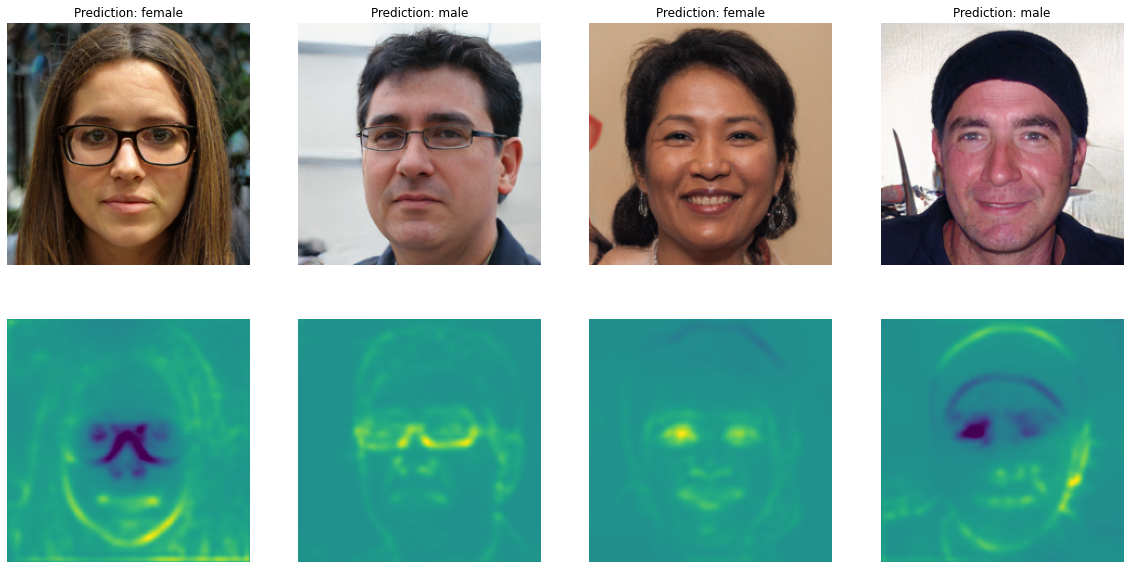

In [ ]:
rules = ['flat', None,      # conv1
         'flat',              # pooling
         'flat', None,      # conv2
         'flat',              # pooling
         'alphabeta', None, # conv3_1
         'alphabeta', None, # conv3_2
         'alphabeta',         # pooling
         'alphabeta', None, # conv4_1
         'alphabeta', None, # conv4_2
         'alphabeta',         # pooling
         'alphabeta', None, # conv5_1
         'alphabeta', None, # conv5_2
         'alphabeta',         # pooling
         'epsilon', None, None, # fc1, ReLU Dropout 
         'epsilon', None, None, # fc2, ReLU Dropout 
         'epsilon']             # fc3 

example_sets = [['face0.png', 'face1.png', 'face2.png', 'face3.png'], 
                ['face4.png', 'face5.png', 'face6.png', 'face7.png'], 
                ['face8.png', 'face9.png', 'face10.png', 'face11.png']
                ]
                
files = example_sets[0]

fig, axs = plt.subplots(2, 4, figsize=(20,10))
class_names = ['male', 'female']
for i in range(0, 4):
    image_raw, image_processed = load_image("data/" + files[i])
    hm, score = lrp_heatmap(model_gender_classification, image_processed, rules, -1)
    print(score)
    axs[0][i].set_title("Prediction: " + class_names[np.argmax(score)])

    axs[0][i].imshow(image_raw)
    axs[0][i].axis('off')
    axs[1][i].imshow(hm, vmin=-np.max(hm), vmax=np.max(hm))
    axs[1][i].axis('off')

plt.show()

You can see that wearing glasses contributes to the class male and contradicts the class female. This behavior of the DNN was caused by an undesired correlation in the training dataset. Most of the men in the training data are wearing glasses, but only a few woman do so. The DNN thus learned that wearing glasses is a common feature for the class "male".

You are not convinced? Try different images by changing the line *files = example_sets[0]* to *files = example_sets[1]* or *files = example_sets[2]* for more examples.



##**Exercise: Counting Leaves - What is Clever-Hans doing here?**

In this exercise you have to use LRP to find out what the detector is doing to distinguish between three different classes of seedlings. For one class you can find a behavior that we can certainly describe as Clever-Hans behavior. The network that you have to analyze was trained to distinguish between images of seedlings with one, two and four leaves.
The original data is from https://vision.eng.au.dk/leaf-counting-dataset/ (Teimouri et al. Weed Growth Stage Estimator Using Deep Convolutional Neural Networks. Sensors. 2018; 18(5):1580. https://doi.org/10.3390/s18051580). We resized them and added an undesired correlation between the content of the images and the classes.

And again we define another auxiliary function to read and preprocess images:

You can load an image from the datasets by selecting a class (1,2 or 3) and an image id between 1 and 16. If you select an invalid class or image id, the function will return a black image.

In [ ]:
def load_leaf_image(class_number, image_id):
    if class_number < 1 or class_number > 3:
      return np.zeros(shape=(228,228,3)), np.zeros(shape=(224,224,3))
    
    if image_id < 1 or image_id > 16:
      return np.zeros(shape=(228,228,3)), np.zeros(shape=(224,224,3)) 

    imgRaw = Image.open("data/set{}_{:02d}.png".format(class_number, image_id))
    imgRaw.load()
    img = np.asarray(imgRaw, dtype="float32")   
    img = np.transpose(img, (2,0,1))
    img = (img[2::-1, 2:-2, 2:-2]) / 255.0
    img = 2.0*(img-0.5)

    return imgRaw, img

Initialize the DNN and load the weights:

This time we use a slightly different architecture that is depicted/ilustrated in the following image. A summary is also printed by the function model.eval().

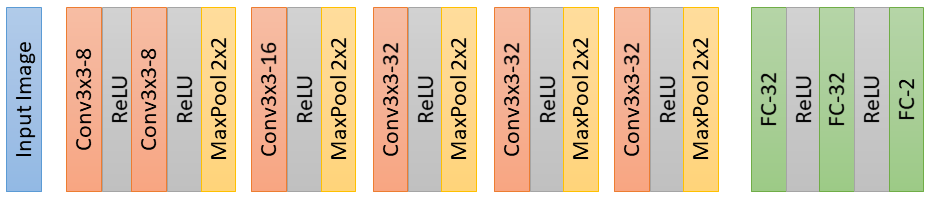


In [ ]:
model = SimpleDNN(32, num_classes=3)
model.load_state_dict(torch.load("data/LeafNet_19.pt", map_location=torch.device('cpu')))
model.eval()

SimpleClassificationNet(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 32, kernel_size=(3

Now it is up to you to define appropriate LRP rules and select images to uncover what is "wrong" with the classifier.
You have to:


*   Define which LRP rules should be used. To do so, change the strings 'convX', 'pooling' and 'fcX' in the list *rules* to 'flat', 'alphabeta' or 'epsilon'.
*   Select different data to see on which regions the DNN focuses to make its decision. You can do so by changing the values in the lists class_id and image_id.




unknown LRP type:fc3
unknown LRP type:fc2
unknown LRP type:fc1
unknown LRP type:pooling
unknown LRP type:conv6
unknown LRP type:pooling
unknown LRP type:conv5
unknown LRP type:pooling
unknown LRP type:conv4
unknown LRP type:pooling
unknown LRP type:conv3
unknown LRP type:pooling
unknown LRP type:conv2
unknown LRP type:conv1


TypeError: ignored

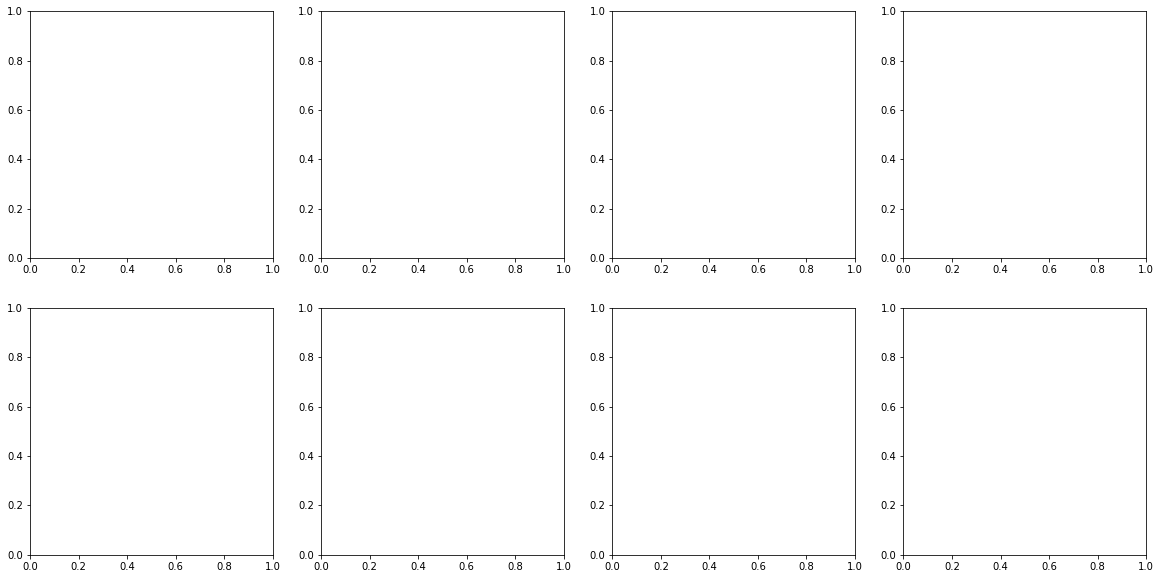

In [ ]:
"""  
rules = ['conv1', 'ReLU',
         'conv2', 'ReLU',
         'pooling',
         'conv3', 'ReLU',
         'pooling',
         'conv4', 'ReLU',
         'pooling',
         'conv5', 'ReLU',
         'pooling',
         'conv6', 'ReLU',
         'pooling',
         'fc1', 'ReLU', 'fc2', 'ReLU', 'fc3']
"""

# Change convX, pooling and fcX in the follow. If you want to try it again from
# scratch, you can copy the rules from above.
rules = ['conv1', 'ReLU',
         'conv2', 'ReLU',
         'pooling',
         'conv3', 'ReLU',
         'pooling',
         'conv4', 'ReLU',
         'pooling',
         'conv5', 'ReLU',
         'pooling',
         'conv6', 'ReLU',
         'pooling',
         'fc1', 'ReLU', 'fc2', 'ReLU', 'fc3']


fig, axs = plt.subplots(2, 4, figsize=(20,10))
class_names = ['one leaf', 'two leaves', 'four leaves']

class_id = [1,1,1,1]
image_id = [1,2,3,4]

for i in range(0, 4):
    image_raw, image_processed = load_leaf_image(class_id[i], image_id[i])
    hm, score = lrp_heatmap(model, image_processed, rules, -1)
    print(score)
    axs[0][i].set_title("Prediction: " + class_names[np.argmax(score)])
    axs[0][i].imshow(hm, vmin=-np.max(hm), vmax=np.max(hm))
    axs[0][i].axis('off')
    axs[1][i].imshow(image_raw)
    axs[1][i].axis('off')

plt.show()


**Further Literature:**
If you liked our examples and are further interested in LRP, check how and 
where it can be applied to feature layers instead of the final classification layer: *Focused LRP: Explainable AI for Face Morphing Attack Detection* by Clemens Seibold, Anna Hilsmann and Peter Eisert (DOI: [10.1109/WACVW52041.2021.00014](https://doi.org/10.1109/WACVW52041.2021.00014))



**Minor Remarks on possible warnings:**
Don't worry about the Warning: 
*UserWarning: Named tensors and all....*
(keep calm, see https://github.com/pytorch/pytorch/pull/60059 and wait for the next PyTorch release)